# Imports

In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
from scipy.stats import norm, gamma
import seaborn as sns
from sklearn.neighbors import KernelDensity
from theano import tensor as tt

%matplotlib inline

# Load empirical data and reference distribution

In [2]:
reference_data = pd.read_csv('reference_data_for_empirical_dist.csv')
empirical_n_loans = len(reference_data)
empirical_cltvs = reference_data['cltv_total_initial']
min_cltv = empirical_cltvs.min()
max_cltv = empirical_cltvs.max()
range_cltv = max_cltv - min_cltv

In [3]:
with open('reference_distribution.pkl', 'rb') as filepath:
    reference_distribution = pickle.load(filepath)

In [4]:
x_grid = np.linspace(reference_distribution.x_points.min(), reference_distribution.x_points.max(), 1000000)
pdf_grid = np.exp(reference_distribution.logp(x_grid).eval())

reference_distribution_mean = (pdf_grid * x_grid).sum() / pdf_grid.sum()
reference_distribution_mean

15418.951818586927

In [5]:
pd.Series(reference_distribution.random(size=1000000)).describe()

count    1000000.000000
mean       15435.823500
std        15966.335046
min       -15198.316593
25%         5822.418354
50%        10415.034787
75%        19708.109544
max       309766.914776
dtype: float64

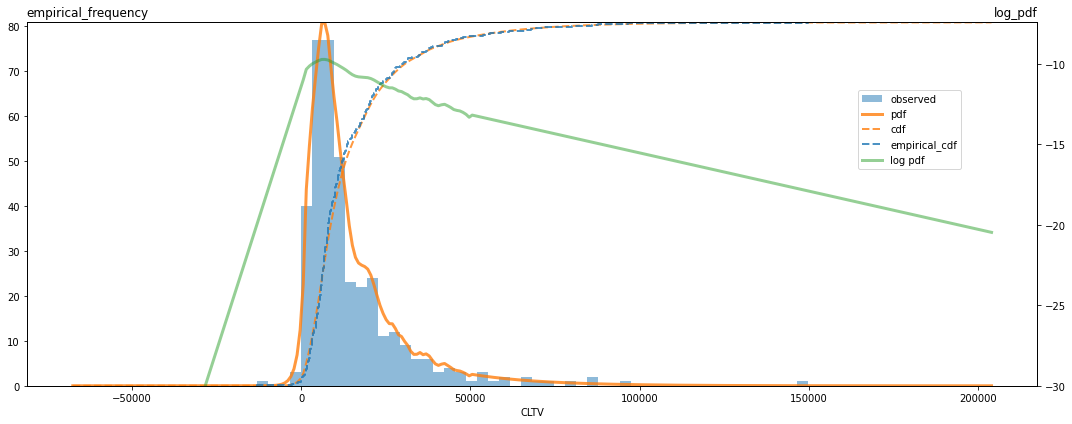

In [6]:
x = np.linspace(min_cltv - range_cltv/3, max_cltv + range_cltv/3, 300)
y_pdf = np.exp(reference_distribution.logp(x).eval())
y_pdf /= max(y_pdf)
y_cdf = np.cumsum(y_pdf) / sum(y_pdf)
y_log = reference_distribution.logp(x).eval()

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax3.set_ylim(bottom = -30)
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

# Datasets

In [7]:
SCALING_FACTOR = np.exp(-0.2)
SHIFT_AMOUNT = 5000.

In [8]:
reference_sample = reference_distribution.random(size=1000)
scaled = reference_distribution.random(size=1000) * SCALING_FACTOR
shifted_negative = reference_distribution.random(size=1000) - SHIFT_AMOUNT
shifted_positive = reference_distribution.random(size=1000) + SHIFT_AMOUNT
scaled_then_shifted = reference_distribution.random(size=1000) * np.exp(0.3) - 7000
mixture_of_scaled = np.concatenate([reference_distribution.random(size=500) * 0.5,
                                            reference_distribution.random(size=500) * 1.5])
small_sample = reference_distribution.random(size=10)
large_sample = reference_distribution.random(size=10000)

In [9]:
datasets = {
    'reference_sample': reference_sample,
    'scaled': scaled,
    'shifted_negative': shifted_negative,
    'shifted_positive': shifted_positive,
    'scaled_then_shifted': scaled_then_shifted,
    'mixture_of_scaled': mixture_of_scaled,
    'small_sample': small_sample,
#     'large_sample': large_sample,
}

In [10]:
traces = {d: {} for d in datasets}

# Parameterisations

### Scaling factor

In [11]:
for d in datasets:
    with pm.Model():
        # prior
        log_scale_factor = pm.Uniform('log_scale_factor', -2.0, 2.0)

        # calculate the correct density in the transformed space
        def transformed_logp(value):
            return reference_distribution.logp(value/tt.exp(log_scale_factor)) - log_scale_factor

        # learn posterior for observed data
        cltv = pm.DensityDist('cltv', transformed_logp, observed=np.array(datasets[d]))
        traces[d]['scaling_factor'] = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.7160493522862321, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


### Scaling factor followed by a translation

In [12]:
# assumes shift happens after scaling
for d in datasets:
    with pm.Model():
        # prior
        log_scale_factor = pm.Uniform('log_scale_factor', -2.0, 2.0)
        translation = pm.Uniform('translation', -30000, 30000)

        # calculate the correct density in the transformed space
        def transformed_logp(value):
            return reference_distribution.logp((value-translation)/tt.exp(log_scale_factor)) - log_scale_factor

        # learn posterior for observed data
        cltv = pm.DensityDist('cltv', transformed_logp, observed=np.array(datasets[d]))
        traces[d]['scaling_factor_plus_translation'] = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [translation, log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [translation, log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [translation, log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [translation, log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [translation, log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [translation, log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [translation, log_scale_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### Smooth probability transform `p(x) -> p(x) * k * exp(x * tau)`

In [13]:
x_grid = np.linspace(reference_distribution.x_points.min(), reference_distribution.x_points.max(), 100000)
pdf_grid = np.exp(reference_distribution.logp(x_grid).eval())

for d in datasets:
    with pm.Model():
        # prior
        tau = pm.Uniform('tau', -0.0002, 0.00005)

        # tau determines k as area under pdf must sum to 1.0
        tau_grid = pdf_grid * tt.exp(x_grid * tau)
        k = pdf_grid.sum() / tau_grid.sum()

        # calculate the correct density in the transformed space
        def transformed_logp(value):
            return reference_distribution.logp(value) + (tau * value) + tt.log(k)

        # learn posterior for observed data
        cltv = pm.DensityDist('cltv', transformed_logp, observed=np.array(datasets[d]))
        traces[d]['smooth_transform'] = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [14]:
def get_cltv_ratios_from_scale_then_shift(trace):
    scale = np.exp(trace.posterior.log_scale_factor.values).ravel()
    loc = trace.posterior.translation.values.ravel()
    return ((reference_distribution_mean * scale) + loc) / reference_distribution_mean

def get_cltv_ratios_from_smooth_transform(trace):
    tau = trace.posterior.tau.values.ravel()
    tau_grid = pdf_grid * np.exp(np.multiply.outer(x_grid, tau)).T
    k = (pdf_grid.sum() / tau_grid.sum(axis=1)).reshape(-1,1)
    return (k * tau_grid * x_grid).sum(axis=1) / (pdf_grid * x_grid).sum()

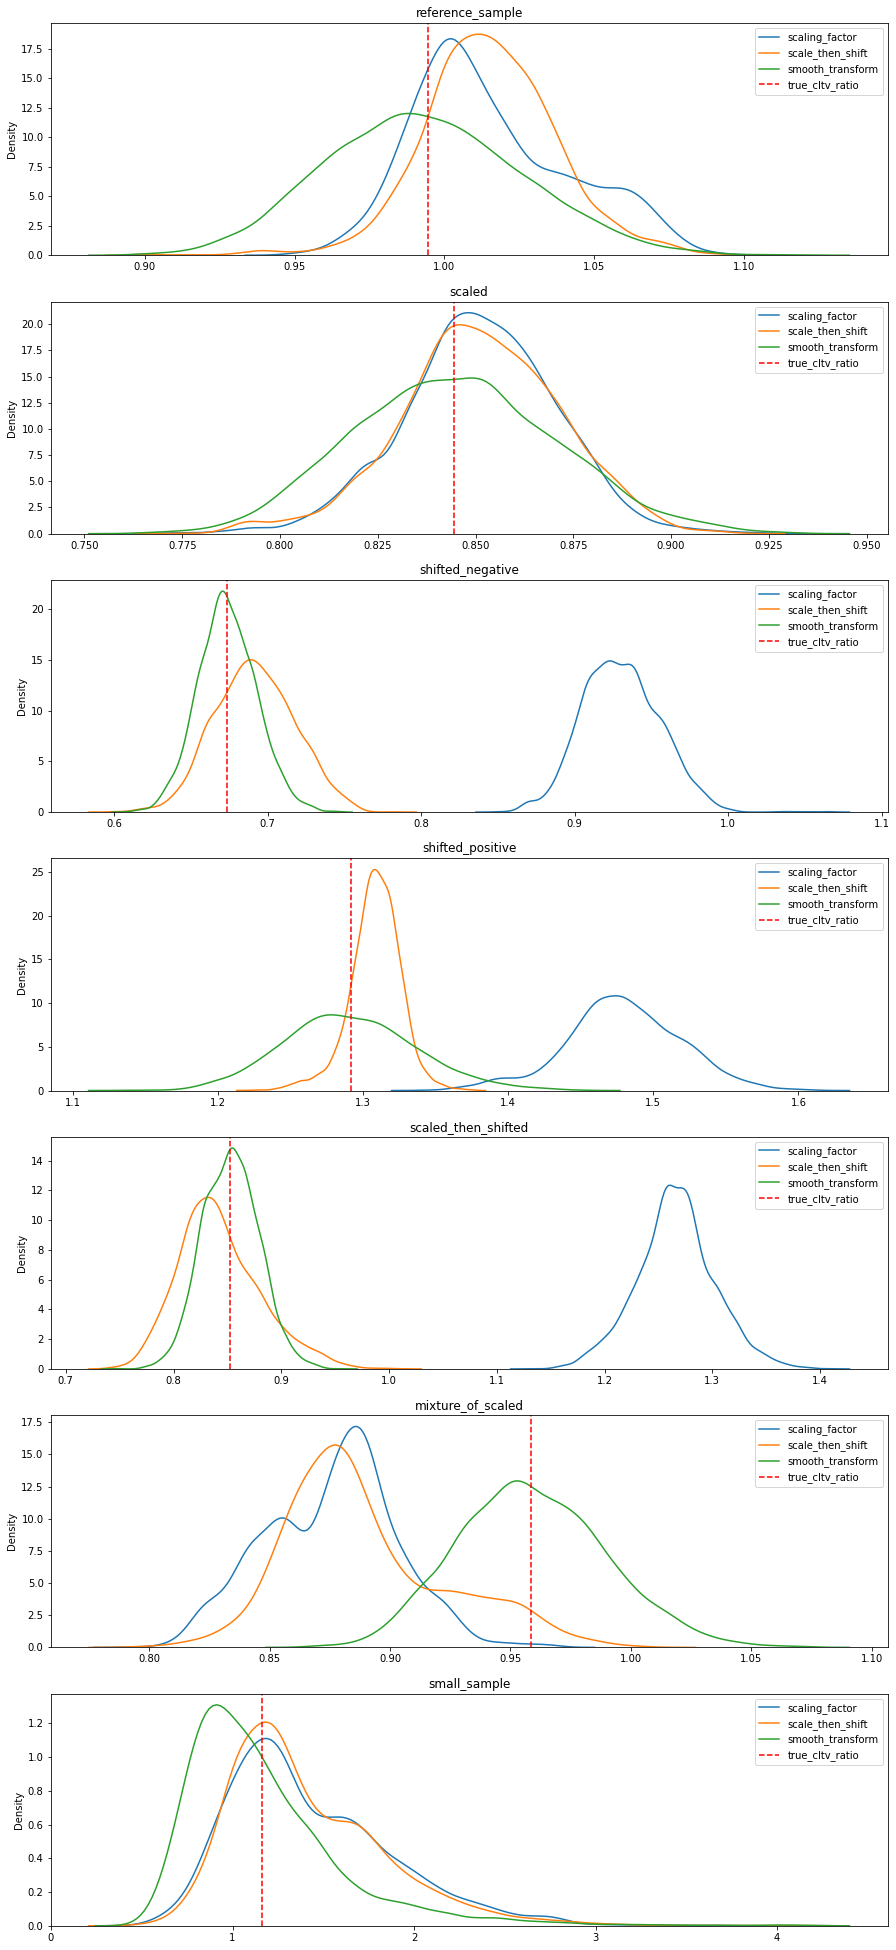

In [15]:
fig, axs = plt.subplots(len(datasets), figsize=(15, 5*len(datasets)))
for i, d in enumerate(datasets):
    # calculate CLTV of sample
    scale_then_shift_cltv_ratios = get_cltv_ratios_from_scale_then_shift(traces[d]['scaling_factor_plus_translation'])
    smooth_transform_cltv_ratios = get_cltv_ratios_from_smooth_transform(traces[d]['smooth_transform'])
    
    # plot distribution of CLTV value learned by each parameterisation
    sns.kdeplot(np.exp(traces[d]['scaling_factor'].posterior.log_scale_factor.values.ravel()),
                ax=axs[i],
                label='scaling_factor')
    sns.kdeplot(scale_then_shift_cltv_ratios, ax=axs[i], label='scale_then_shift')
    sns.kdeplot(smooth_transform_cltv_ratios, ax=axs[i], label='smooth_transform')
    
    # plot actual CLTV ratio as a vertical line
    axs[i].axvline(datasets[d].mean() / reference_distribution_mean, color='r', ls='--', label='true_cltv_ratio')
    axs[i].legend()
    axs[i].set_title(d)

# Appendix 1

### Mixture of two scaled reference distributions

Not used as this was unreliable in learning well

In [16]:
# for d in datasets:
#     with pm.Model():
#         # prior
#         log_scale_factor1 = pm.Uniform('log_scale_factor1', -2.0, 2.0)
#         log_scale_factor2_diff = pm.Uniform('log_scale_factor2_diff', 0.0, 4.0)
#         log_scale_factor2 = log_scale_factor1 + log_scale_factor2_diff
#         share_of_component_1 = pm.Uniform('share_of_component_1', 0.0, 1.0)
#         share_of_component_2 = 1 - share_of_component_1

#         # calculate the correct density in the transformed space
#         def transformed_logp(value):
#             p_from_mix_1 = share_of_component_1 * tt.exp(reference_distribution
#                                                          .logp(value/tt.exp(log_scale_factor1))
#                                                          - log_scale_factor1)
#             p_from_mix_2 = share_of_component_2 * tt.exp(reference_distribution
#                                                          .logp(value/tt.exp(log_scale_factor2))
#                                                          - log_scale_factor2)
#             return tt.log(p_from_mix_1 + p_from_mix_2)

#         # learn posterior for observed data
#         cltv = pm.DensityDist('cltv', transformed_logp, observed=np.array(datasets[d]))
#         traces[d]['mixture_model'] = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

# Appendix 2: Thoughts on coming up with a prior over the scale factor
A common test setup is to have control and test branches where we are looking to estimate the uplift of some metric on the test branch relative to the control branch. Usually we will collect the prior over this uplift from the business. However we also need a prior over the baseline level of the metric in the control branch in order to interpret the observed data from both branches in true A/B fashion.

If the metric in question is `E(CLTV|loan)`, and we expect that the control branch will behave similarly to the recent past, we could use recent loan values to derive a prior over the control scale factor as follows: update an initial non-informative prior (e.g. uniform in log space between sufficiently wide bounds) to yield the posterior distribution over scale factor for these recent observed data. Use this as the control branch prior over the scale factor for our test. The strength of this prior could be altered by flexing the number of recent loans used (e.g. by (down)sampling at regular intervals in the cdf of recent loans) - analogous to dividing the parameters of a beta prior to adjust for relative confidence - or applying a stretching factor to the resultant prior e.g. by a factor - analogous to the √n that determines sample standard deviation for a normal distribution.
